# Imports

In [1]:
import time
import json
import os



import pandas as pd
import numpy as np


import torch
print(torch.__version__)  # Should print a compatible version
print(torch.cuda.is_available())

import tsai
from tsai.basics import*


import matplotlib.pyplot as plt
%matplotlib inline

import lightning.pytorch as pl
from lightning.pytorch import Trainer
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import EncoderNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters




2.2.2+cu121
True


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_forecasting/models/base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Data Loading

In [14]:
master_quant = pd.read_csv("../Data/time_series_data.csv")
master_sentiment_mistral = pd.read_csv("../Outputs/mistral_combined.csv")
master_sentiment_bert= pd.read_csv("../Outputs/bert_combined.csv")

In [3]:
master_quant

,Date,S&P 500,Interest Rate,VIX,OVX,USO,DXY,Crude Oil
0,01/01/21,NaN,0.09,NaN,NaN,NaN,89.94,NaN
1,02/01/21,NaN,0.09,NaN,NaN,NaN,NaN,NaN
2,03/01/21,NaN,0.09,NaN,NaN,NaN,NaN,NaN
3,04/01/21,3700.65,0.09,26.97,42.12,32.38,89.87,47.47
4,05/01/21,3726.86,0.09,25.34,40.39,33.94,89.44,49.78
...,...,...,...,...,...,...,...,...
1396,28/10/24,5823.52,NaN,NaN,42.96,70.43,104.32,67.65
1397,29/10/24,5832.92,NaN,NaN,42.47,69.66,104.32,NaN
1398,30/10/24,5813.67,NaN,NaN,41.13,71.36,103.99,NaN
1399,31/10/24,5705.45,NaN,NaN,48.79,73.08,103.98,NaN


In [4]:
master_sentiment_mistral

,Date,arabnews,cnbc,ei,ft,mees,oilprice,opec
0,2021-01-04,0.4,0.0,0.5,-0.5,0.4,0.4,0.0
1,2021-01-05,0.4,0.4,0.5,0.5,0.4,0.7,0.4
2,2021-01-06,0.4,0.4,0.5,-0.5,0.4,0.7,0.4
3,2021-01-07,0.4,0.7,0.5,0.5,0.4,0.5,0.4
4,2021-01-08,0.4,0.7,0.5,0.4,-0.5,0.5,0.4
...,...,...,...,...,...,...,...,...
1371,2024-10-06,0.0,0.0,0.4,0.0,-0.3,0.6,0.4
1372,2024-10-07,0.0,0.5,0.6,0.6,-0.3,0.7,0.4
1373,2024-10-08,0.0,-0.3,-0.3,-0.5,-0.3,0.7,0.4
1374,2024-10-09,0.0,0.3,-0.3,0.4,-0.3,-0.5,0.4


In [8]:
master_sentiment_bert

,Date,arabnews,cnbc,ei,ft,mees,oilprice
0,2021-01-04,0.519839,0.000000,0.889924,-0.569241,0.000000,0.000000
1,2021-01-05,0.519839,0.000000,0.889924,-0.560321,0.000000,-0.526396
2,2021-01-06,0.519839,0.000000,0.889924,-0.654790,0.000000,-0.526396
3,2021-01-07,0.519839,0.848916,0.889924,0.644426,0.000000,0.000000
4,2021-01-08,0.519839,0.848916,0.889924,0.764327,-0.626426,0.711697
...,...,...,...,...,...,...,...
1371,2024-10-06,0.000000,0.652695,0.000000,0.000000,0.000000,-0.788622
1372,2024-10-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1373,2024-10-08,0.586104,0.000000,-0.603633,-0.496074,0.000000,0.000000
1374,2024-10-09,0.586104,0.000000,0.000000,0.000000,0.000000,0.000000


# Data Cleaning and Preprocessing

In [15]:
cols =  ['Date', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy', 'crude']
cols_mistral = ['Date', 'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m', 'opec_m']
cols_bert = ['Date', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b', 'oilprice_b']


master_quant.columns = cols
master_sentiment_mistral.columns = cols_mistral
master_sentiment_bert.columns = cols_bert

In [16]:
master_quant.columns

Index(['Date', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy',
       'crude'],
      dtype='object')

In [17]:
master_quant[cols]= master_quant[cols].fillna(method='ffill')
master_quant

,Date,s_p_500,interest_rate,vix,ovx,uso,dxy,crude
0,01/01/21,NaN,0.09,NaN,NaN,NaN,89.94,NaN
1,02/01/21,NaN,0.09,NaN,NaN,NaN,89.94,NaN
2,03/01/21,NaN,0.09,NaN,NaN,NaN,89.94,NaN
3,04/01/21,3700.65,0.09,26.97,42.12,32.38,89.87,47.47
4,05/01/21,3726.86,0.09,25.34,40.39,33.94,89.44,49.78
...,...,...,...,...,...,...,...,...
1396,28/10/24,5823.52,5.13,20.93,42.96,70.43,104.32,67.65
1397,29/10/24,5832.92,5.13,20.93,42.47,69.66,104.32,67.65
1398,30/10/24,5813.67,5.13,20.93,41.13,71.36,103.99,67.65
1399,31/10/24,5705.45,5.13,20.93,48.79,73.08,103.98,67.65


In [18]:
master_quant= master_quant.iloc[3:]
master_quant.reset_index(drop = True, inplace = True)

In [19]:
master_quant

,Date,s_p_500,interest_rate,vix,ovx,uso,dxy,crude
0,04/01/21,3700.65,0.09,26.97,42.12,32.38,89.87,47.47
1,05/01/21,3726.86,0.09,25.34,40.39,33.94,89.44,49.78
2,06/01/21,3748.14,0.09,25.07,39.31,34.11,89.53,50.45
3,07/01/21,3803.79,0.09,22.37,36.06,34.53,89.83,50.63
4,08/01/21,3824.68,0.09,21.56,36.65,35.43,90.10,52.14
...,...,...,...,...,...,...,...,...
1393,28/10/24,5823.52,5.13,20.93,42.96,70.43,104.32,67.65
1394,29/10/24,5832.92,5.13,20.93,42.47,69.66,104.32,67.65
1395,30/10/24,5813.67,5.13,20.93,41.13,71.36,103.99,67.65
1396,31/10/24,5705.45,5.13,20.93,48.79,73.08,103.98,67.65


In [20]:
zero_counts = (master_quant[cols] == 0).sum()
print(zero_counts)


Date              0
s_p_500           0
interest_rate     0
vix               0
ovx               0
uso               0
dxy               0
crude            34
dtype: int64


In [21]:
master_quant['crude'] = master_quant['crude'].replace(0).fillna(method='ffill')



SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [22]:
zero_counts = (master_quant[cols] == 0).sum()
print(zero_counts)

Date             0
s_p_500          0
interest_rate    0
vix              0
ovx              0
uso              0
dxy              0
crude            0
dtype: int64


In [23]:
master_quant['vix'] = master_quant['vix'].replace('.').fillna(method='ffill')


SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [33]:
master_quant['vix'] = master_quant['vix'].apply(lambda x: float(x))

SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [34]:
master_quant.dtypes

Date             datetime64[ns]
s_p_500                 float64
interest_rate           float64
vix                     float64
ovx                     float64
uso                     float64
dxy                     float64
crude                   float64
dtype: object

In [35]:
master_quant['Date'] = pd.to_datetime(master_quant['Date'], format='%d/%m/%y') #important as not doing this will lead to issues with tsai splits

SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [36]:
master_sentiment_mistral['Date'] = pd.to_datetime(master_sentiment_mistral['Date'], format='%Y-%m-%d') #important as not doing this will lead to issues with tsai splits
master_sentiment_bert['Date'] = pd.to_datetime(master_sentiment_bert['Date'], format='%Y-%m-%d') #important as not doing this will lead to issues with tsai splits


In [27]:
master_sentiment_mistral

,Date,arabnews_m,cnbc_m,ei_m,ft_m,mees_m,oilprice_m,opec_m
0,2021-01-04,0.4,0.0,0.5,-0.5,0.4,0.4,0.0
1,2021-01-05,0.4,0.4,0.5,0.5,0.4,0.7,0.4
2,2021-01-06,0.4,0.4,0.5,-0.5,0.4,0.7,0.4
3,2021-01-07,0.4,0.7,0.5,0.5,0.4,0.5,0.4
4,2021-01-08,0.4,0.7,0.5,0.4,-0.5,0.5,0.4
...,...,...,...,...,...,...,...,...
1371,2024-10-06,0.0,0.0,0.4,0.0,-0.3,0.6,0.4
1372,2024-10-07,0.0,0.5,0.6,0.6,-0.3,0.7,0.4
1373,2024-10-08,0.0,-0.3,-0.3,-0.5,-0.3,0.7,0.4
1374,2024-10-09,0.0,0.3,-0.3,0.4,-0.3,-0.5,0.4


In [37]:
master_df = master_quant.merge(master_sentiment_mistral, how = 'inner', on = 'Date')

In [38]:
master_df = master_df.merge(master_sentiment_bert, how = 'inner', on = 'Date')

In [44]:
master_df.to_csv('../Outputs/Data_Master.csv', index = False)

In [43]:
os.getcwd()

'/scratch/us2055/Oil_Price/Notebooks'

# EDA

In [45]:
master_df.columns

Index(['Date', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy', 'crude',
       'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m',
       'opec_m', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
       'oilprice_b'],
      dtype='object')

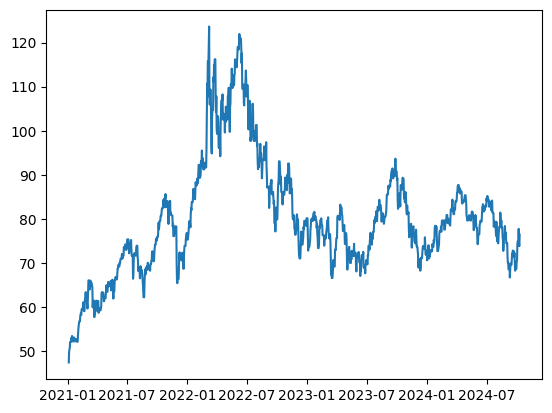

In [46]:
plt.plot(master_df['Date'], master_df['crude'])

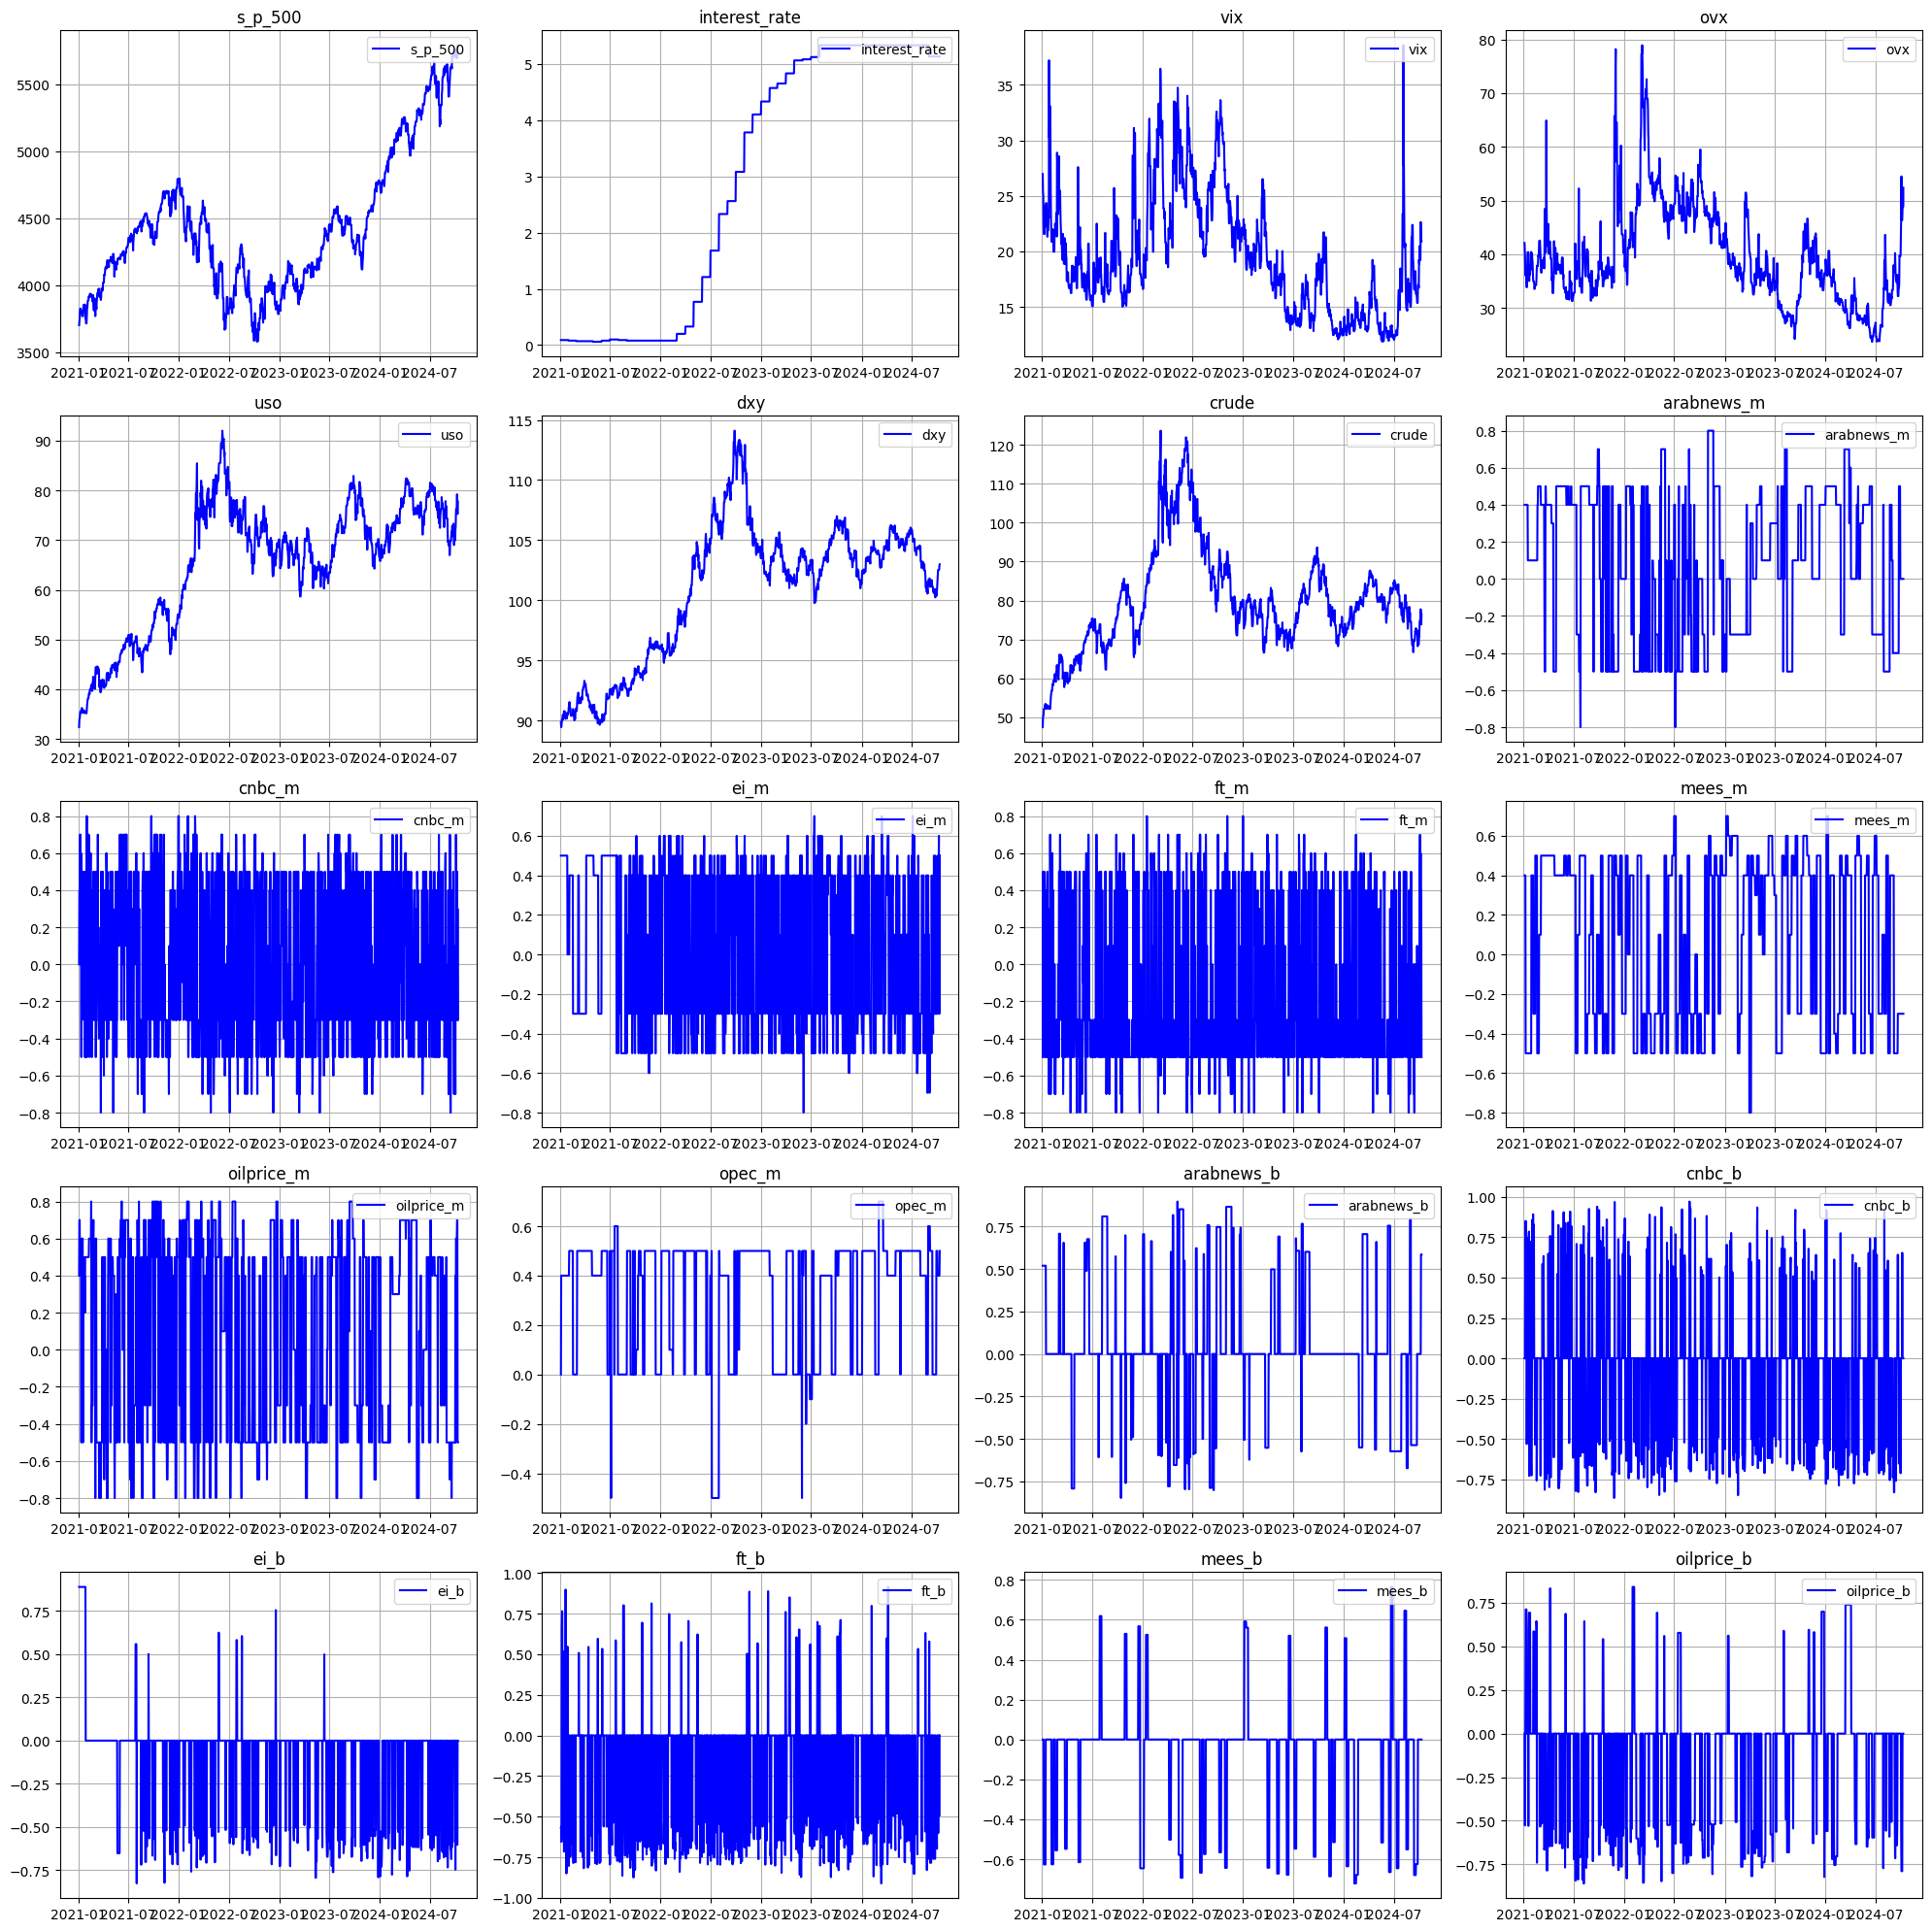

In [41]:
import matplotlib.pyplot as plt
import math

# List of variables to plot (excluding 'Date')
variables = [
    's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy', 'crude',
    'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m',
    'opec_m', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
    'oilprice_b'
]

# Number of variables and layout configuration
num_vars = len(variables)
plots_per_row = 4
num_rows = math.ceil(num_vars / plots_per_row)

# Set up the figure and axes for subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=plots_per_row, figsize=(20, num_rows * 4))

# Flatten axes for easier iteration
axes = axes.flatten()

# Plot each variable
for i, var in enumerate(variables):
    axes[i].plot(master_df['Date'], master_df[var], label=var, color='blue')
    axes[i].set_title(var)
    axes[i].grid(True)
    axes[i].legend(loc='upper right')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


# Data Prep for Modelling

In [55]:
CALENDAR_CYCLES= {
    "weekday": 7,
    "week": 52,
    "month": 12,
}

In [57]:
def add_cyclical_calendar_features(df: pd.DataFrame, date_col: str, features: Union[str, List[str]]):
    """Cyclical encoding of calendar features based on a date column."""
    
    if isinstance(features, str):
        features = [features]

    # Ensure the date column is datetime
    df[date_col] = pd.to_datetime(df[date_col])

    for feat in features:
        assert (
            feat in CALENDAR_CYCLES.keys()
        ), f"Cyclical encoding is not available for {feat}"

        if feat == "week":
            # Use ISO calendar week
            values = df[date_col].dt.isocalendar().week
        else:
            # For other features (weekday, month), use .dt accessor
            values = getattr(df[date_col].dt, feat)

        # Apply cyclical encoding
        df[f"{feat}_sin"] = np.sin(2 * np.pi * values / CALENDAR_CYCLES[feat])
        df[f"{feat}_cos"] = np.cos(2 * np.pi * values / CALENDAR_CYCLES[feat])

    return df


In [58]:
master_df_processed= add_cyclical_calendar_features(master_df, 'Date', features=["weekday", "week", 'month'])
master_df_processed

,Date,s_p_500,interest_rate,vix,ovx,uso,dxy,crude,arabnews_m,cnbc_m,...,ei_b,ft_b,mees_b,oilprice_b,weekday_sin,weekday_cos,week_sin,week_cos,month_sin,month_cos
0,2021-01-04,3700.65,0.09,26.97,42.12,32.38,89.87,47.47,0.4,0.0,...,0.889924,-0.569241,0.000000,0.000000,0.000000,1.000000,0.120537,0.992709,0.500000,0.866025
1,2021-01-05,3726.86,0.09,25.34,40.39,33.94,89.44,49.78,0.4,0.4,...,0.889924,-0.560321,0.000000,-0.526396,0.781831,0.623490,0.120537,0.992709,0.500000,0.866025
2,2021-01-06,3748.14,0.09,25.07,39.31,34.11,89.53,50.45,0.4,0.4,...,0.889924,-0.654790,0.000000,-0.526396,0.974928,-0.222521,0.120537,0.992709,0.500000,0.866025
3,2021-01-07,3803.79,0.09,22.37,36.06,34.53,89.83,50.63,0.4,0.7,...,0.889924,0.644426,0.000000,0.000000,0.433884,-0.900969,0.120537,0.992709,0.500000,0.866025
4,2021-01-08,3824.68,0.09,21.56,36.65,35.43,90.10,52.14,0.4,0.7,...,0.889924,0.764327,-0.626426,0.711697,-0.433884,-0.900969,0.120537,0.992709,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371,2024-10-06,5751.07,5.13,19.21,46.37,76.35,102.52,74.93,0.0,0.0,...,0.000000,0.000000,0.000000,-0.788622,-0.781831,0.623490,-0.992709,0.120537,-0.866025,0.500000
1372,2024-10-07,5695.94,5.13,22.64,48.32,79.20,102.54,77.76,0.0,0.5,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-0.970942,0.239316,-0.866025,0.500000
1373,2024-10-08,5751.13,5.13,21.42,52.35,75.79,102.55,74.26,0.0,-0.3,...,-0.603633,-0.496074,0.000000,0.000000,0.781831,0.623490,-0.970942,0.239316,-0.866025,0.500000
1374,2024-10-09,5792.04,5.13,20.86,48.80,75.25,102.93,73.85,0.0,0.3,...,0.000000,0.000000,0.000000,0.000000,0.974928,-0.222521,-0.970942,0.239316,-0.866025,0.500000


In [59]:
master_df_processed["weekend"] = (master_df_processed['Date'].dt.dayofweek > 4).astype(int)

In [65]:
split = round(len(master_df_processed)*0.8)
print(split)

train = master_df_processed.iloc[: split]
test = master_df_processed.iloc[split:]


1101


In [73]:
# datetime_col = 'Date'
# fcst_history = 50 # # steps in the past
# fcst_horizon = 16 # # steps in the future
# valid_size   = 0.1  # int or float indicating the size of the training set
# test_size    = 0.2  # int or float indicating the size of the test set

# splits = get_forecasting_splits(master_df_processed, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
#                                 valid_size=valid_size, test_size=test_size)
# splits


In [74]:
# train_data = master_df_processed.iloc[splits[0]]
# test_data = master_df_processed.iloc[splits[2]]
# val_data = master_df_processed.iloc[splits[1]]


In [ ]:
# print(train_data.shape)
# print(val_data.shape)
# print(test_data.shape)

In [66]:
train= train.reset_index()
train= (train.merge((train[['Date']].drop_duplicates(ignore_index=True).rename_axis('time_idx')).reset_index(), on = ['Date'])).drop(["Date"], axis=1)

In [75]:
train.shape

(1101, 29)

In [86]:
train.isna().sum()

index            0
s_p_500          0
interest_rate    0
vix              0
ovx              0
uso              0
dxy              0
crude            0
arabnews_m       0
cnbc_m           0
ei_m             0
ft_m             0
mees_m           0
oilprice_m       0
opec_m           0
arabnews_b       0
cnbc_b           0
ei_b             0
ft_b             0
mees_b           0
oilprice_b       0
weekday_sin      0
weekday_cos      0
week_sin         0
week_cos         0
month_sin        0
month_cos        0
weekend          0
time_idx         0
dtype: int64

In [ ]:
 group_ids = ['s_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy', 'crude',
       'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m',
       'opec_m', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
       'oilprice_b', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos',
       'week_sin', 'week_cos', 'weekend']

In [103]:
constant= [1 for item in train['vix']]
train['constant'] = constant

# Model Building

In [258]:
max_encoder_length = 50
max_prediction_length = 16
training_cutoff = train["time_idx"].max() - max_prediction_length # validation on 2020


training_dataset = TimeSeriesDataSet(
    train[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="crude", # target variable
    max_encoder_length=max_encoder_length, # maximum size of lookup window
    max_prediction_length=max_prediction_length, # maximum size of horizon window
    group_ids = ['constant'], 
    time_varying_known_reals=[
        "time_idx", 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin', 'weekend'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['crude', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy',
       'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m',
       'opec_m', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
       'oilprice_b'], 
    target_normalizer=EncoderNormalizer(),
    lags={'crude': [7,365]}, # add lagged values of target variable
    predict_mode = True
)

In [253]:
max_encoder_length = 50
max_prediction_length = 16
training_cutoff = train["time_idx"].max() - max_prediction_length # validation on 2020


training_dataset = TimeSeriesDataSet(
    train[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="crude", # target variable
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    group_ids = ['constant'], 
    time_varying_known_reals=[
        "time_idx", 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin', 'weekend'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['crude', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy',
       'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m',
       'opec_m', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
       'oilprice_b'], 
    target_normalizer=EncoderNormalizer(),
    lags={'crude': [7,365]}, # add lagged values of target variable
    predict_mode = True
)





In [259]:
validation_dataset = TimeSeriesDataSet.from_dataset(
  training_dataset, # dataset from which to copy parameters (encoders, scalers, ...)
  train, # data from which new dataset will be generated
  predict=True, # predict the decoder length on the last entries in the time index
  stop_randomization=True,
)

In [262]:
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate= 0.01862087136662867,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8, 
    loss=MAE(),
    # logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 38.2k


## LR Finder

In [257]:
trainer = pl.Trainer(
    accelerator="gpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr: 100%|██████████| 100/100 [02:52<00:00,  1.73s/it]
Learning rate set to 0.01862087136662867
Restoring states from the checkpoint path at /scratch/us2055/Oil_Price/Notebooks/.lr_find_3302da1c-a9f6-443e-b0ea-57e416a9194c.ckpt
Restored all states from the checkpoint at /scratch/us2055/Oil_Price/Notebooks/.lr_find_3302da1c-a9f6-443e-b0ea-57e416a9194c.ckpt


suggested learning rate: 0.01862087136662867


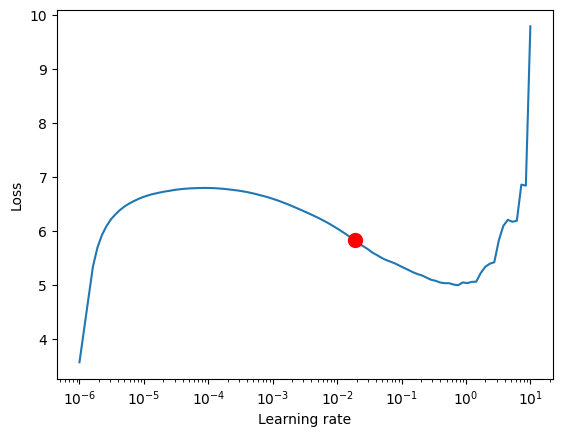

In [261]:
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

## Training

In [263]:
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    gradient_clip_val=0.1,
    
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [264]:
batch_size = 64  # set this between 32 to 128
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

In [265]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 448    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 0      | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 20.0 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 4.4 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm |

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  6.18it/s, v_num=5.39e+7, train_loss_step=7.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, v_num=5.39e+7, train_loss_step=1.370, val_loss=2.250, train_loss_epoch=7.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s, v_num=5.39e+7, train_loss_step=1.360, val_loss=2.110, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s, v_num=5.39e+7, train_loss_step=2.030, val_loss=1.310, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s, v_num=5.39e+7, train_loss_step=1.150, val_loss=1.810, train_loss_epoch=2.030]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s, v_num=5.39e+7, train_loss_step=1.610, val_loss=2.790, train_loss_epoch=1.150]
Validation: 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.53it/s, v_num=5.39e+7, train_loss_step=1.120, val_loss=1.840, train_loss_epoch=1.120]


In [235]:
predictions = tft.predict(val_dataloader, return_y=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


In [267]:
MAE()(predictions.output, predictions.y)

tensor(6.2504, device='cuda:0')

In [278]:
raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


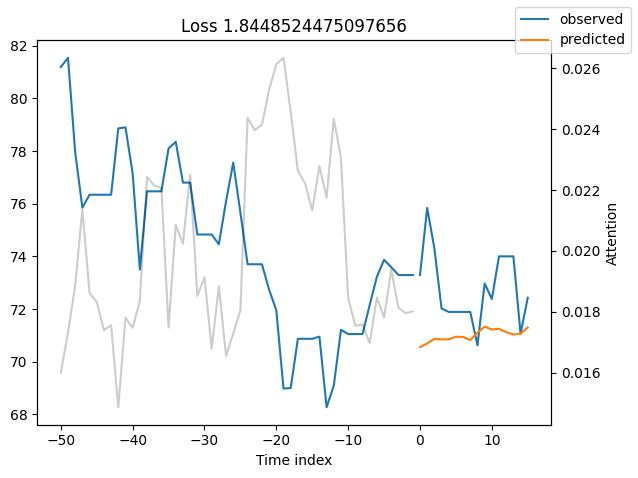

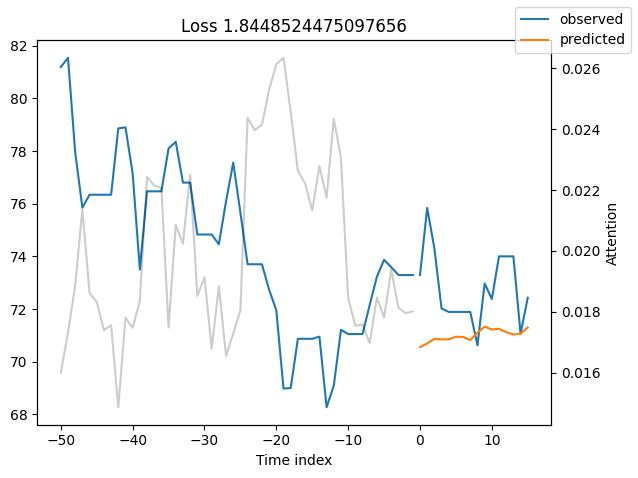

In [280]:
  # plot 10 examples
tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx = 0, add_loss_to_title=True)

In [149]:
for idx in range(val_prediction_results.prediction.shape[0]): # nb of groups combinations
    fig, ax = plt.subplots(figsize=(23,5))
    best_tft.plot_prediction(val_prediction_results.x, # network input
                            val_prediction_results.output, # network output
                            idx=idx,
                            add_loss_to_title=True,
                            ax=ax);

AttributeError: 'Prediction' object has no attribute 'prediction'